# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

### Loading libraries and defining constants

In [1]:
import pickle
import os
import pickle
from urllib.request import urlretrieve
from zipfile import ZipFile

import random
import numpy as np
import csv
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

DATASET_ZIP_URL        = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'
DATASET_ZIP_FILE       = 'traffic-signs-data.zip'
DATASET_DIR            = 'traffic-signs-data'
TRAINING_FILE          = 'train.p'
VALIDATION_FILE        = 'valid.p'
TESTING_FILE           = 'test.p'
SIGN_NAMES_FILE        = 'signnames.csv'
DATA_SUMMARY_FILE      = 'data_summary.png'

### Loading Data

In [2]:
def download(url, file):
    if os.path.exists(file):
        print('Skiping download: "' + file + '" already exists.')
        return
    print('Downloading "' + file + '" ...')
    urlretrieve(url, file)
    print('Download finished.')

def unzip(src_zip_file, dest_file):
    if (os.path.exists(dest_file)):
        print('Skiping unzip: "' + dest_file + '" already exists.')
        return
    if (not os.path.exists(src_zip_file)):
        print('Skiping unzip: "' + src_zip_file + '" does not exist.')
        return
    print('Unzipping "' + src_zip_file + '" ...')
    zip = ZipFile(src_zip_file)
    zip.extractall(dest_file)
    print('Unzip finished.')

def loadDataFromFile(data_file):
    with open(data_file, mode='rb') as f:
        data = pickle.load(f)
    return data['features'], data['labels']

download(DATASET_ZIP_URL, DATASET_ZIP_FILE)
unzip(DATASET_ZIP_FILE, DATASET_DIR)

training_file   = os.path.join(DATASET_DIR, TRAINING_FILE)
validation_file = os.path.join(DATASET_DIR, VALIDATION_FILE)
testing_file    = os.path.join(DATASET_DIR, TESTING_FILE)

# Loading pickled training and testing data from files
X_train, y_train = loadDataFromFile(training_file)
X_valid, y_valid = loadDataFromFile(validation_file)
X_test, y_test   = loadDataFromFile(testing_file)

Skiping download: "traffic-signs-data.zip" already exists.
Skiping unzip: "traffic-signs-data" already exists.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# How many unique classes/labels there are in the dataset.
n_classes = max(len(set(y_train)), len(set(y_valid)), len(set(y_test)))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

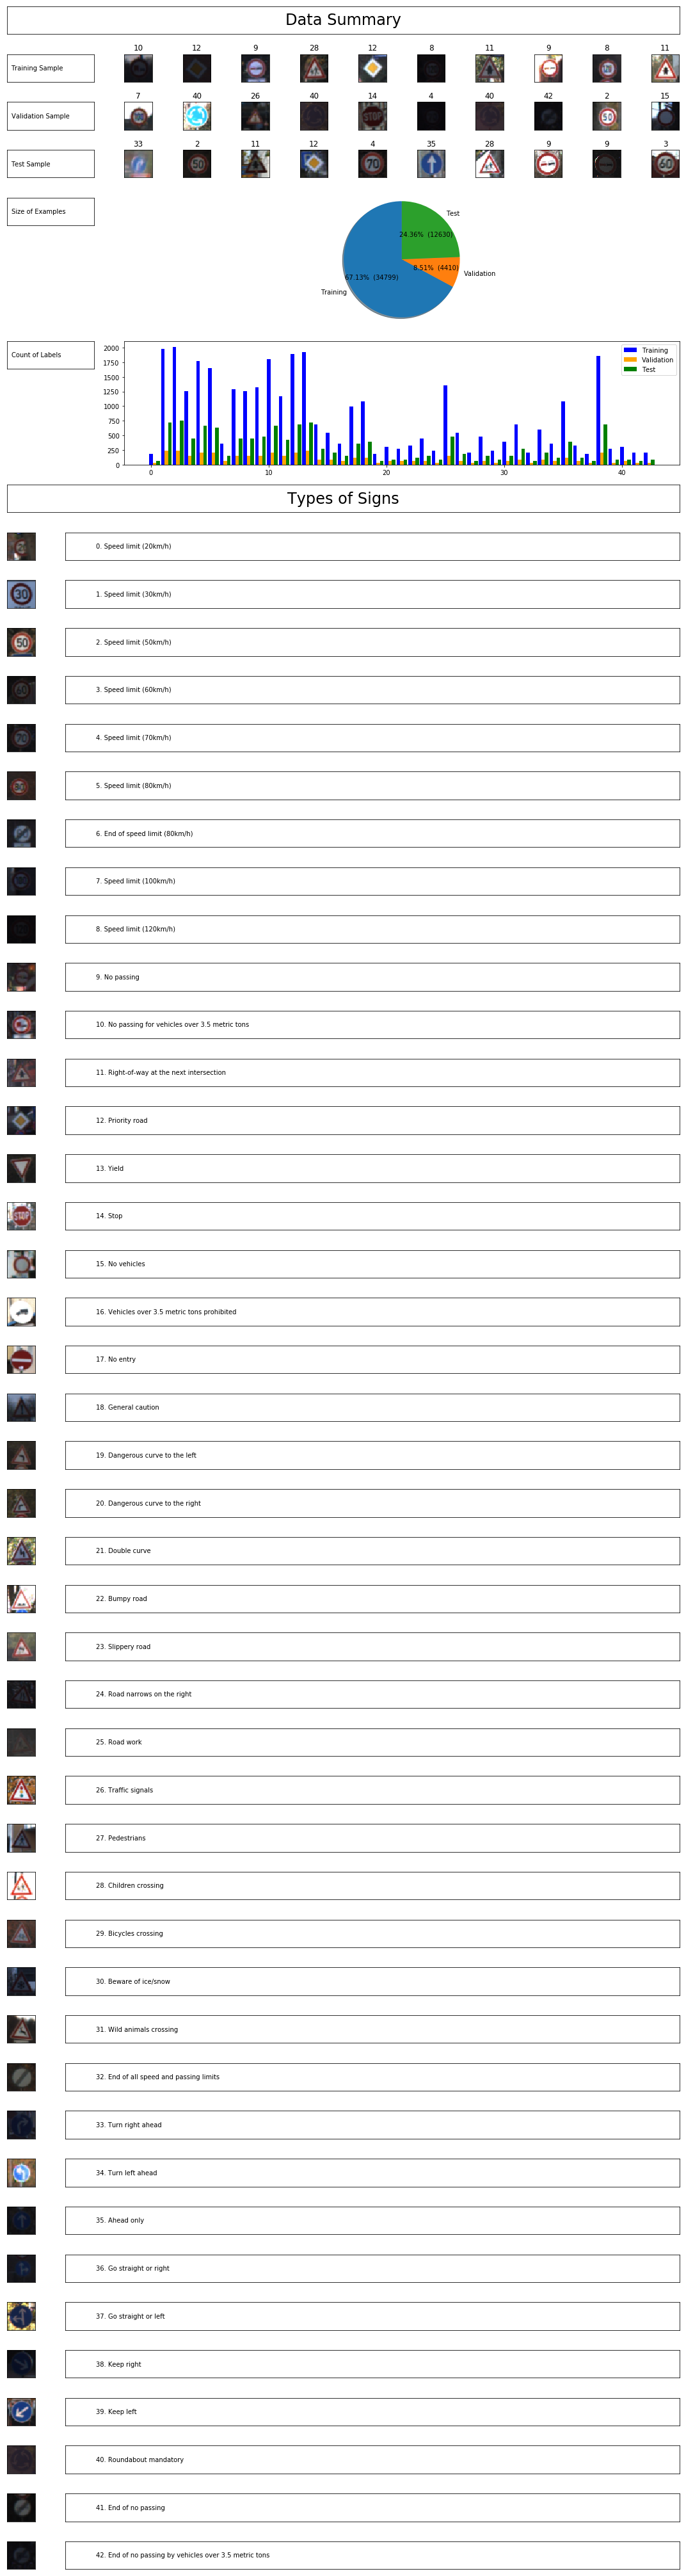

In [4]:
example_names = ('Training', 'Validation', 'Test')
example_sizes = (n_train, n_validation, n_test)

def getNumberOfLabels(labels, no_classes):
    data = [0] * no_classes
    for k, v in Counter(labels).items():
        data[k] = v
    return data

def classifyImagesBylabel(images, labels):
    result = {}
    for i in range(len(labels)):
        label = labels[i]
        image = images[i]
        if label not in result:
            result[label] = []
        result[label].append(image)
    return result

def setTitleInGrid(grid_section, text, font_size):
    ax = plt.subplot(grid_section)
    plt.xticks(())
    plt.yticks(())
    plt.text(0.5, 0.5, text, ha='center', va='center', size=font_size, alpha=1.0)

def setTextInGrid(grid_section, text, font_size):
    ax = plt.subplot(grid_section)
    plt.xticks(())
    plt.yticks(())
    plt.text(0.05, 0.5, text, ha='left', va='center', size=font_size, alpha=1.0)

def setImageInGrid(grid_section, img, label=None):
    ax = plt.subplot(grid_section)
    plt.xticks(())
    plt.yticks(())
    ax.imshow(img)
    if label is not None:
        ax.set_title(label)

def setRandomImagesInGrid(grid_spec, row, from_col, images, labels, no_images):
    radom_indices = random.sample(range(len(images)), no_images)
    for i in range(len(radom_indices)):
        idx = radom_indices[i]
        img = images[idx]
        label = labels[idx]
        setImageInGrid(grid_spec[row, from_col + i], img, label)

def setExampleSizesPieInGrid(grid_section):
    ax = plt.subplot(grid_section)

    def make_custom_autopct(values):
        def custom_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
        return custom_autopct
    
    explode = (0.0, 0.0, 0.0)
    ax.pie(example_sizes, explode=explode, labels=example_names,
           autopct=make_custom_autopct(example_sizes),
           shadow=True, startangle=90)
    ax.axis('equal')

def setLabelsCountInGrid(grid_section):
    ax = plt.subplot(grid_section)
    width = 0.3
    labels = np.arange(0, n_classes, 1)
    rects1 = ax.bar(labels, getNumberOfLabels(y_train, n_classes), width, color='blue')
    rects2 = ax.bar(labels + width, getNumberOfLabels(y_valid, n_classes), width, color='orange')
    rects3 = ax.bar(labels + 2 * width, getNumberOfLabels(y_test, n_classes), width, color='green')
    ax.legend((rects1[0], rects2[0], rects3[0]), example_names)

plt.figure(figsize=(15, 12 + 1 + n_classes))
grid_spec = gridspec.GridSpec(10 +  1 + n_classes, 12)
setTitleInGrid(grid_spec[0, :], 'Data Summary', 24)
# Drawing random example images
setTextInGrid(grid_spec[1, 0:2], example_names[0] + ' Sample', 10)
setRandomImagesInGrid(grid_spec, 1, 2, X_train, y_train, 10)
setTextInGrid(grid_spec[2, 0:2], example_names[1] + ' Sample', 10)
setRandomImagesInGrid(grid_spec, 2, 2, X_valid, y_valid, 10)
setTextInGrid(grid_spec[3, 0:2], example_names[2] + ' Sample', 10)
setRandomImagesInGrid(grid_spec, 3, 2, X_test, y_test, 10)
# Drawing pie chart with the sizes of the examples
setTextInGrid(grid_spec[4, 0:2], "Size of Examples", 10)
setExampleSizesPieInGrid(grid_spec[4:7, 2:]);
# Drawing bar graph with the count of labels
setTextInGrid(grid_spec[7, 0:2], "Count of Labels", 10)
setLabelsCountInGrid(grid_spec[7:10, 2:])

# Drawing the types of images
setTitleInGrid(grid_spec[10, :], 'Types of Signs', 24)
images_by_label = classifyImagesBylabel(X_valid, y_valid)
with open(SIGN_NAMES_FILE, 'rt') as csvfile:
    reader = csv.DictReader(csvfile)
    row_idx = 10 + 1
    img_type_idx = 0
    for row in reader:
        rand_idx = random.randrange(len(images_by_label[img_type_idx]))
        setImageInGrid(grid_spec[row_idx, 0], images_by_label[img_type_idx][rand_idx])
        setTextInGrid(grid_spec[row_idx, 1:], row['ClassId'] + '. ' + row['SignName'], 10)
        row_idx += 1
        img_type_idx += 1

### Data exploration visualization
plt.tight_layout()
plt.savefig(DATA_SUMMARY_FILE)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Importing TensorFlow among other libraries and defining constants

In [5]:
# Importing necessary libraries

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn.utils import resample

CLASSIFIER_FILE_PREFIX = 'classifier'

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
# Re-loading pickled training and testing data from files (for further pre-processing tries)
X_train, y_train = loadDataFromFile(training_file)
X_valid, y_valid = loadDataFromFile(validation_file)
X_test, y_test   = loadDataFromFile(testing_file)

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

def normalizeColorComponent(color_value):
    norm_min  = -1.0
    norm_max  = 1.0
    color_max = 255.0
    color_min = 0.0
    return norm_min + (color_value - color_min) * (norm_max - norm_min) / (color_max - color_min)

def normalizeAndAddBwLayer(X):
    no_images = len(X)
    X_preproc = np.zeros((no_images, 32, 32, 4))
    X_preproc[:, :, :, 0:3] = normalizeColorComponent(X)
    # Adding a B/W layer using Luma
    X_preproc[:, :, :, 3] = normalizeColorComponent(0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2])
    return X_preproc

def preProcessImages(X):
    # Adding a B/W layer to the images that transforms them from size 32x32x3 to 32x32x4
    return normalizeAndAddBwLayer(X)

def preProcessData(X, y):
    return preProcessImages(X), y

X_train, y_train = preProcessData(X_train, y_train)
X_valid, y_valid = preProcessData(X_valid, y_valid)
X_test,  y_test  = preProcessData(X_test,  y_test)

### Neural Network for Classifier

In [8]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
MU    = 0.0
SIGMA = 0.1

# Types of Layers

def convolutional2D(X, filter_height, filter_width, input_depth, output_depth, name):
    w_shape = (filter_height, filter_width, input_depth, output_depth)
    conv_W = tf.Variable(tf.truncated_normal(shape = w_shape, mean = MU, stddev = SIGMA), name = name + '_w')
    conv_b = tf.Variable(tf.zeros(output_depth), name = name + '_b')
    conv = tf.nn.conv2d(X, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b
    return conv

def fullyConnected(X, no_inputs, no_outputs, name):
    w_shape = (no_inputs, no_outputs)
    fc_W = tf.Variable(tf.truncated_normal(shape = w_shape, mean = MU, stddev = SIGMA), name = name + '_w')
    fc_b = tf.Variable(tf.zeros(no_outputs), name = name + '_b')
    fc = tf.matmul(X, fc_W) + fc_b
    return fc

def maxPool(X, k=2):
    return tf.nn.max_pool(X, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def activation(X):
    return tf.nn.relu(X)

def classifier(x):    
    # Layer 1: Convolutional. Input = 32x32x4. Output = 28x28x32.
    conv1 = activation(convolutional2D(x, 5, 5, 4, 32, "conv1"))
    # Pooling. Input = 28x28x32. Output = 14x14x32.
    maxpool_conv1 = maxPool(conv1)

    # Layer 2: Convolutional. Output = 10x10x64.
    conv2 = activation(convolutional2D(maxpool_conv1, 5, 5, 32, 64, "conv2"))
    # Pooling. Input = 10x10x64. Output = 5x5x64.
    maxpool_conv2 = maxPool(conv2)

    # Flatten. Input = 5x5x64. Output = 1600.
    fc0   = flatten(maxpool_conv2)

    # Layer 3: Fully Connected. Input = 1600. Output = 1200.
    fc1 = activation(fullyConnected(fc0, 1600, 1200, "fc1"))

    # Layer 4: Fully Connected. Input = 1200. Output = 1024.
    fc2 = activation(fullyConnected(fc1, 1200, 1024, "fc2"))

    # Layer 5: Fully Connected. Input = 1024. Output = n_classes.
    logits = fullyConnected(fc2, 1024, n_classes, "logits")

    # Returning the layer of the Neural Network, useful to Visualize the Neural Network's State (step 4)
    return {'conv1'         : conv1,
            'maxpool_conv1' : maxpool_conv1,
            'conv2'         : conv2,
            'maxpool_conv2' : maxpool_conv2,
            'fc0'           : fc0,
            'fc1'           : fc1,
            'fc2'           : fc2,
            'logits'        : logits}

### Model Evaluation

In [9]:
def evaluate(X_data, y_data, batch_size, accuracy_operation):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset : offset + batch_size], y_data[offset : offset + batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict = {x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Setting up Traininig Pipeline

In [10]:
EPOCHS             = 50
BATCH_SIZE         = 128
LEARNING_RATE      = 0.001
MIN_ACCURACY       = 0.945

x                  = tf.placeholder(tf.float32, (None, 32, 32, 4))
y                  = tf.placeholder(tf.int32, (None))
one_hot_y          = tf.one_hot(y, n_classes)

classifier_layers  = classifier(x)

logits             = classifier_layers['logits']
cross_entropy      = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)
loss_operation     = tf.reduce_mean(cross_entropy)
optimizer          = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver              = tf.train.Saver()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training

In [11]:
### Training the model.
### Calculating and reporting the accuracy on the training and validation set.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    model_saved = False
    prev_validation_accuracy = 0.0

    print('Training...')
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid, BATCH_SIZE, accuracy_operation)
        print('EPOCH {} ...'.format(i+1))
        print('Validation Accuracy = {:.3f}'.format(validation_accuracy))

        # Checking for early stopping when min accuracy has been reached and
        # training doesn't seem to improve
        if validation_accuracy >= MIN_ACCURACY or prev_validation_accuracy >= MIN_ACCURACY:
            print('Min accuracy reached')
            if validation_accuracy > prev_validation_accuracy:
                print('Accuracy increasing, saving model ...')
                saver.save(sess, CLASSIFIER_FILE_PREFIX)
                model_saved = True
            else:
                print('Accuracy decreasing, keeping the previous saved model ...')
                break
        prev_validation_accuracy = validation_accuracy

        print()

    print()
    print('Training terminated')
    if model_saved:
        print('Model saved')
    else:
        print('Model not saved, min accuracy could not be reached')

Training...

EPOCH 1 ...
Validation Accuracy = 0.844

EPOCH 2 ...
Validation Accuracy = 0.883

EPOCH 3 ...
Validation Accuracy = 0.895

EPOCH 4 ...
Validation Accuracy = 0.892

EPOCH 5 ...
Validation Accuracy = 0.874

EPOCH 6 ...
Validation Accuracy = 0.913

EPOCH 7 ...
Validation Accuracy = 0.906

EPOCH 8 ...
Validation Accuracy = 0.909

EPOCH 9 ...
Validation Accuracy = 0.909

EPOCH 10 ...
Validation Accuracy = 0.905

EPOCH 11 ...
Validation Accuracy = 0.912

EPOCH 12 ...
Validation Accuracy = 0.931

EPOCH 13 ...
Validation Accuracy = 0.918

EPOCH 14 ...
Validation Accuracy = 0.925

EPOCH 15 ...
Validation Accuracy = 0.912

EPOCH 16 ...
Validation Accuracy = 0.911

EPOCH 17 ...
Validation Accuracy = 0.934

EPOCH 18 ...
Validation Accuracy = 0.933

EPOCH 19 ...
Validation Accuracy = 0.917

EPOCH 20 ...
Validation Accuracy = 0.914

EPOCH 21 ...
Validation Accuracy = 0.934

EPOCH 22 ...
Validation Accuracy = 0.906

EPOCH 23 ...
Validation Accuracy = 0.934

EPOCH 24 ...
Validation Accura

### Evaluating the Model

In [12]:
### On the final model architecture, 
### the accuracy on the test set should be calculated and reported as well.

with tf.Session() as sess:
    # Restoring model's variables from saved file
    saver.restore(sess, CLASSIFIER_FILE_PREFIX)
    test_accuracy = evaluate(X_test, y_test, BATCH_SIZE, accuracy_operation)
    print('Test Accuracy = {:.3f}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from classifier
Test Accuracy = 0.938


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

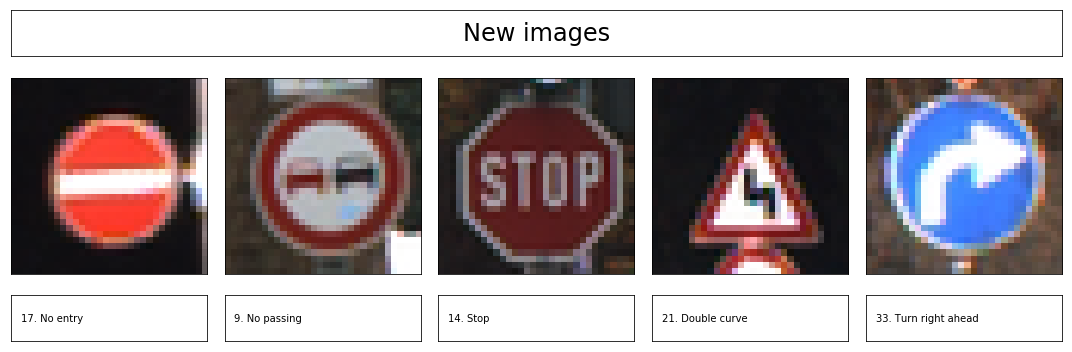

In [13]:
### Loading the new images and plotting them here.

from PIL import Image

NEW_IMAGES_DIR         = 'new_images'
NEW_IMAGES_REPORT_FILE = 'new_images_report.png'

# Getting the map of labels (id, name)
labels_map = {int(row['ClassId']) : row['SignName'] for row in csv.DictReader(open(SIGN_NAMES_FILE, 'rt'))}

# Getting the images from a directory
new_images = []
new_images_labels = []
for filename in os.listdir(NEW_IMAGES_DIR):
    if os.path.isfile(os.path.join(NEW_IMAGES_DIR, filename)):
        img = Image.open(os.path.join(NEW_IMAGES_DIR, filename)).resize((32, 32), Image.ANTIALIAS)
        # Adding an image as a numpy array
        new_images.append(np.asarray(img))
        # Getting the label which is given by the file name
        new_images_labels.append(int(filename.split('.')[0]))

# Setting new images' array as a numpy array
new_images = np.array(new_images)
        
# Drawing the new images with their respective labels
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(6, len(new_images))
setTitleInGrid(grid_spec[0, :], 'New images', 24)
for i in range(len(new_images)):
    setImageInGrid(grid_spec[1:-1, i], new_images[i])
    setTextInGrid(grid_spec[-1, i], str(new_images_labels[i]) + '. ' + labels_map[new_images_labels[i]], 10)
plt.tight_layout()
plt.savefig(NEW_IMAGES_REPORT_FILE)
plt.show()

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from classifier


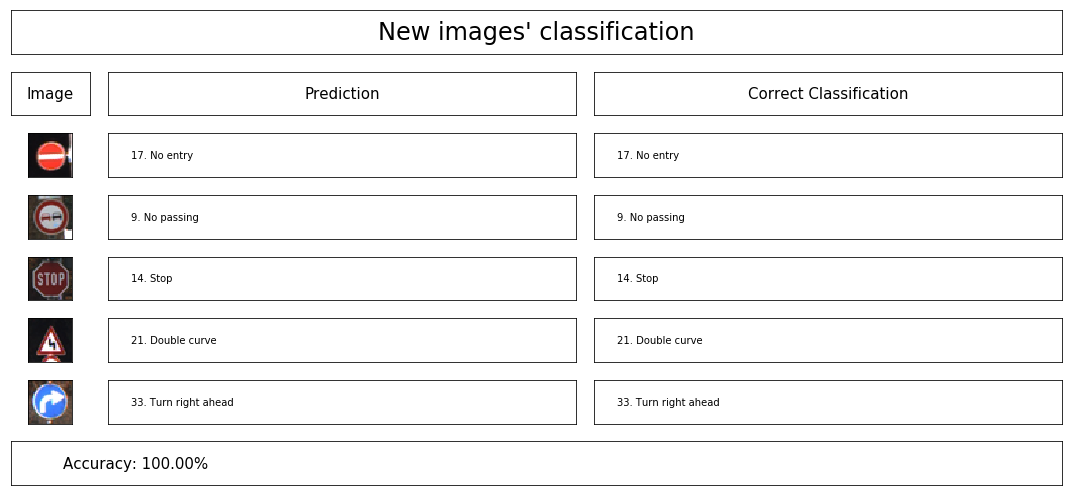

In [14]:
### Running the predictions here and using the model to output the prediction for each image.

NEW_IMAGES_PREDICTION_FILE = 'new_images_predictions.png'

with tf.Session() as sess:
    # Restoring model's variables from saved file
    saver.restore(sess, CLASSIFIER_FILE_PREFIX)
    predictions = sess.run(tf.argmax(logits, 1), feed_dict={x: preProcessImages(new_images)})

accuracy = np.average([1.0 if predictions[i] == new_images_labels[i] else 0.0 for i in range(len(predictions))])

plt.figure(figsize=(15, 7))
grid_spec = gridspec.GridSpec(len(new_images) + 3, 11)
setTitleInGrid(grid_spec[0, :], 'New images\' classification', 24)
setTitleInGrid(grid_spec[1, 0], 'Image', 15)
setTitleInGrid(grid_spec[1, 1:6], 'Prediction', 15)
setTitleInGrid(grid_spec[1, 6:11], 'Correct Classification', 15)

for i in range(len(new_images)):
    # Image
    setImageInGrid(grid_spec[i + 2, 0], new_images[i])
    # Predicted label
    setTextInGrid(grid_spec[i + 2, 1:6], str(predictions[i]) + '. ' + labels_map[predictions[i]], 10)
    # Correct label
    setTextInGrid(grid_spec[i + 2, 6:], str(new_images_labels[i]) + '. ' + labels_map[new_images_labels[i]], 10)

setTextInGrid(grid_spec[-1, 0:], 'Accuracy: {:.2f}%'.format(accuracy * 100), 15)

plt.tight_layout()
plt.savefig(NEW_IMAGES_PREDICTION_FILE)
plt.show()

### Analyze Performance

In [15]:
### Calculating the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# The accuracy was calculated in previous cell, so it's just printed here
print('Accuracy: {:.2f}%'.format(accuracy * 100))

Accuracy: 100.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./classifier
[[17  0  1  2  3]
 [ 9  0  1  2  3]
 [14 17  3 13  0]
 [21 11 19  0  1]
 [33 39  0  1  2]]
[[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   3.61199711e-28   4.36171146e-33   5.02832724e-34
    1.56271459e-34]
 [  1.00000000e+00   4.53464346e-28   2.69320943e-31   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   2.02064842e-38   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]


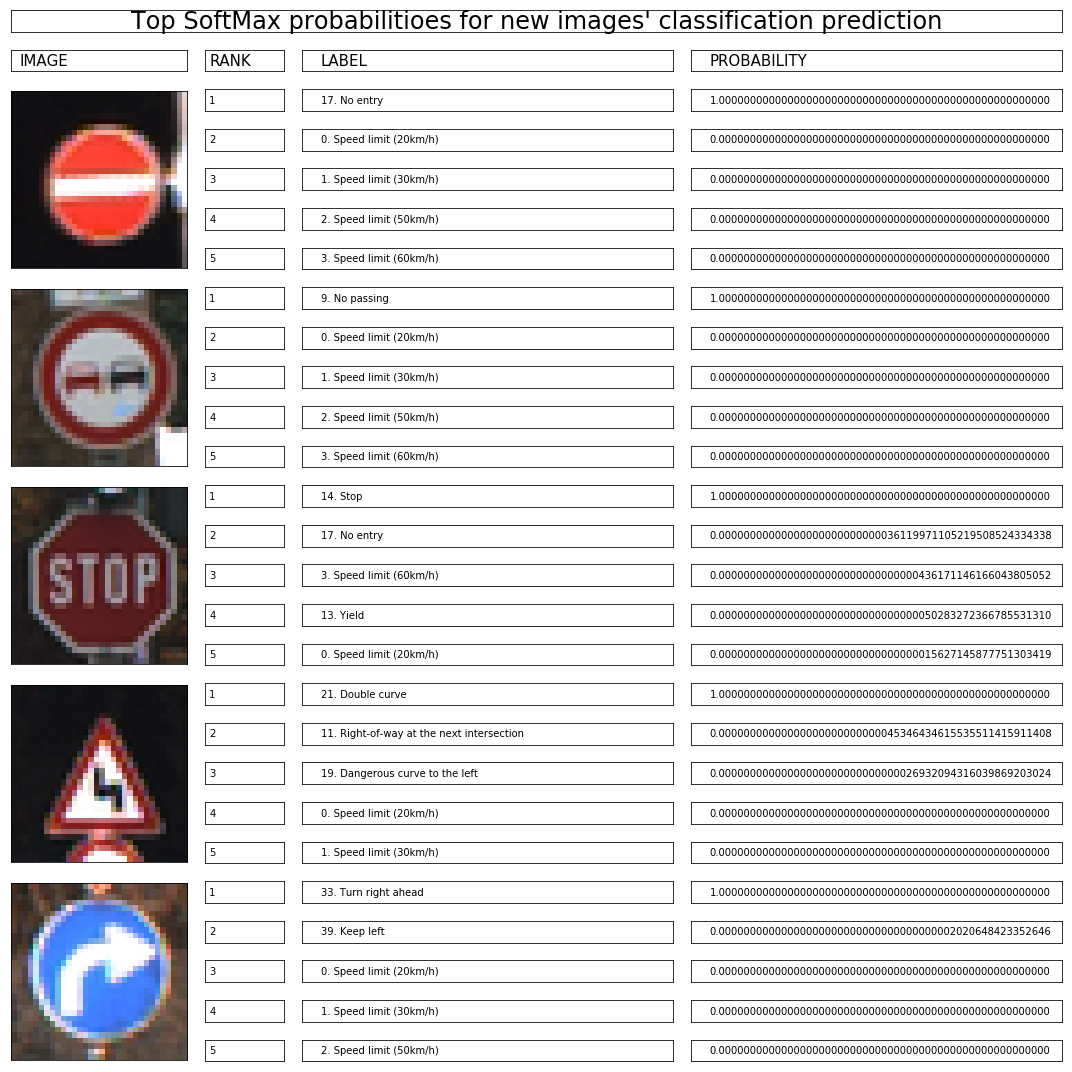

In [16]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

TOP_K = 5
NEW_IMAGES_TOP_PROB_PREDICTION_FILE = 'new_images_top_probability_predictions.png'

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_label_probabilities, top_labels = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=TOP_K ),
                                                   feed_dict={x: preProcessImages(new_images)})
    print(top_labels)
    print(top_label_probabilities)


plt.figure(figsize=(15, 15))
grid_spec = gridspec.GridSpec(len(new_images) * TOP_K + 2, 11)
setTitleInGrid(grid_spec[0, :], 'Top SoftMax probabilitioes for new images\' classification prediction', 24)
setTextInGrid(grid_spec[1, 0:2], 'IMAGE', 15)
setTextInGrid(grid_spec[1, 2], 'RANK', 15)
setTextInGrid(grid_spec[1, 3:-4], 'LABEL', 15)
setTextInGrid(grid_spec[1, -4:], 'PROBABILITY', 15)

for i in range(len(new_images)):
    init_row = i * TOP_K + 2
    # Image
    setImageInGrid(grid_spec[init_row : init_row + TOP_K, 0:2], new_images[i])
    for j in range(TOP_K):
        # Rank
        setTextInGrid(grid_spec[init_row + j, 2], j + 1, 10)
        # Label
        setTextInGrid(grid_spec[init_row + j, 3:-4], str(top_labels[i][j]) + '. ' + labels_map[top_labels[i][j]], 10)
        # SoftMax probability of label
        setTextInGrid(grid_spec[init_row + j, -4:], '{:.53f}'.format(top_label_probabilities[i][j]), 10)

plt.tight_layout()
plt.savefig(NEW_IMAGES_TOP_PROB_PREDICTION_FILE)
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


INFO:tensorflow:Restoring parameters from classifier


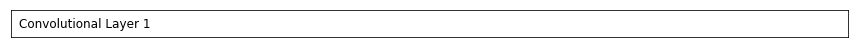

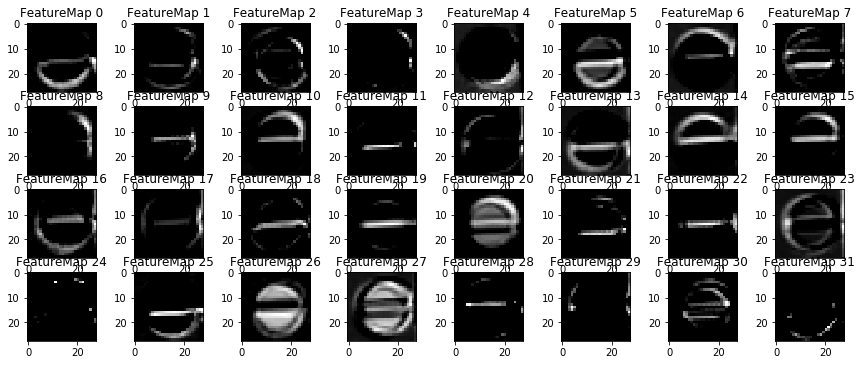

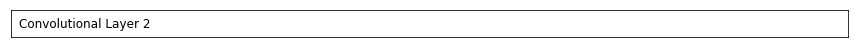

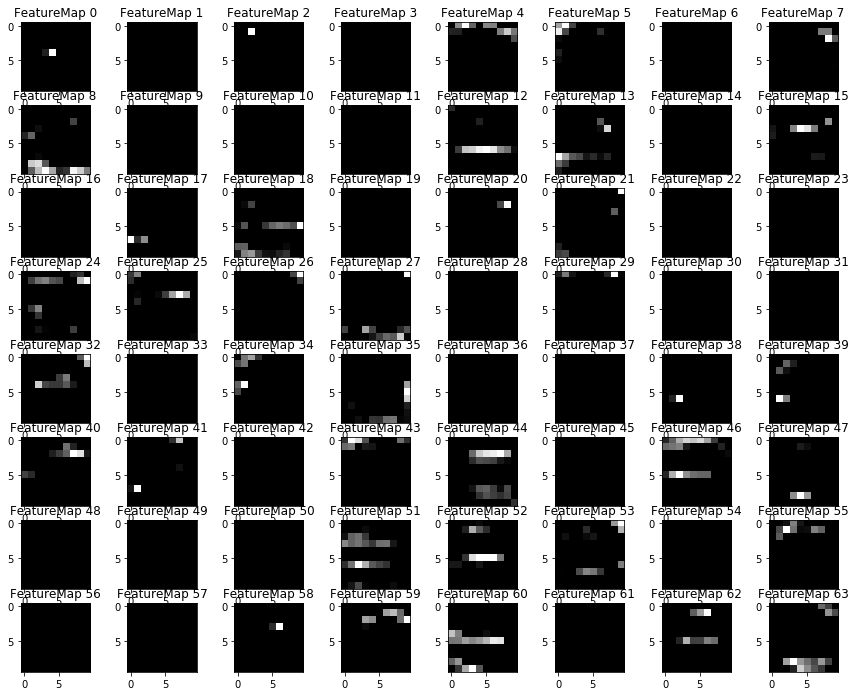

In [17]:
### Visualize your network's feature maps here.

FEATURE_MAP_CONV1_FILE = 'feature_map_conv1.png'
FEATURE_MAP_CONV2_FILE = 'feature_map_conv2.png'

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session = sess, feed_dict = {x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize = (15, 15))
    for featuremap in range(featuremaps):
        plt.subplot(10, 8, featuremap + 1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation = "nearest", vmin = activation_min, vmax = activation_max, cmap = "gray")
        elif activation_max != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation = "nearest", vmax = activation_max, cmap = "gray")
        elif activation_min !=-1:
            plt.imshow(activation[0, :, :, featuremap], interpolation = "nearest", vmin = activation_min, cmap = "gray")
        else:
            plt.imshow(activation[0, :, :, featuremap], interpolation = "nearest", cmap = "gray")

def printLayerTitle(text, plt_num=1):
    plt.figure(plt_num, figsize = (15, 0.5))
    plt.xticks(())
    plt.yticks(())
    plt.text(0.01, 0.5, text, ha='left', va='center', size=12, alpha=1.0)

with tf.Session() as sess:
    saver.restore(sess, CLASSIFIER_FILE_PREFIX)

    printLayerTitle('Convolutional Layer 1', plt_num = 1)
    outputFeatureMap(preProcessImages(new_images), classifier_layers['conv1'], plt_num = 2)
    plt.savefig(FEATURE_MAP_CONV1_FILE)

    printLayerTitle('Convolutional Layer 2', plt_num = 3)
    outputFeatureMap(preProcessImages(new_images), classifier_layers['conv2'], plt_num = 4)
    plt.savefig(FEATURE_MAP_CONV2_FILE)